In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
#plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]

#%matplotlib inline

In [3]:
npzfile0 = np.load('./sber_work_files/final/clients_w_gr_names.npz', allow_pickle=True)

client_df = npzfile0['client_df'] # client, group, day
group_names = npzfile0['group_names']

In [4]:
client_df[:,0,:].shape

(7287, 274)

 ...]

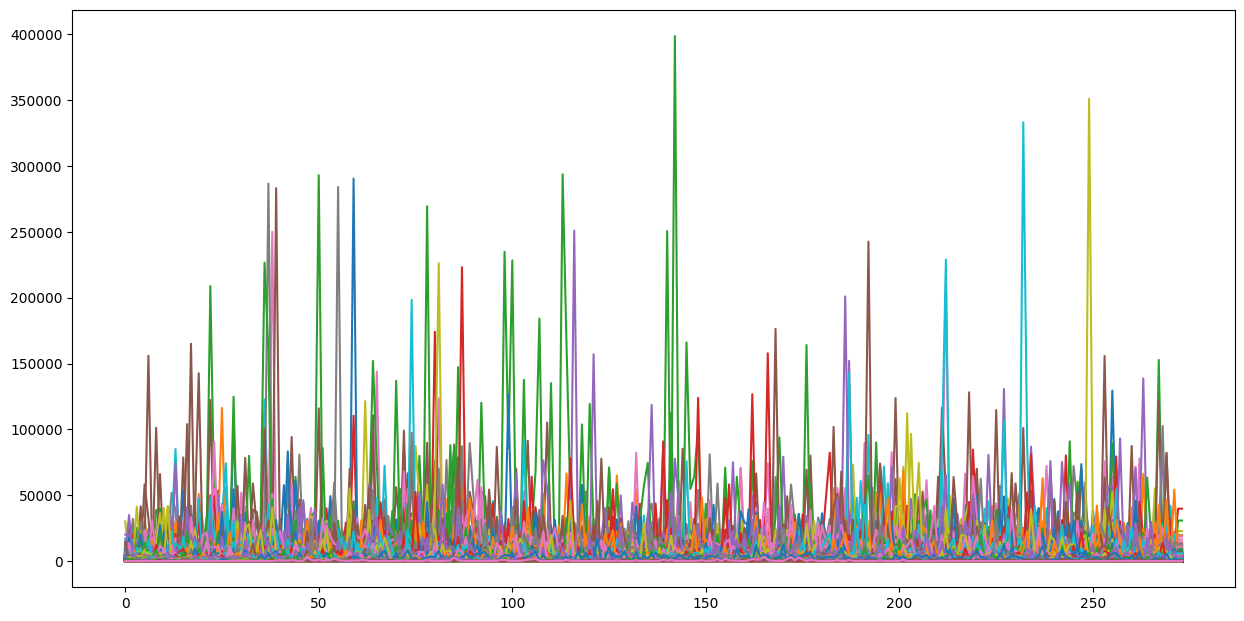

In [5]:
plt.plot(client_df[:,0,:].T)

In [6]:
from sklearn.preprocessing import StandardScaler

list_scalers = []
list_cli = []

for group in range(client_df.shape[1]):
    cur_cli = client_df[:,group,:] # shape 7k, 274
    
    scaler = StandardScaler()
    scaler = scaler.fit(cur_cli)
    list_scalers.append(scaler)
    
    cur_cli_scaled = scaler.transform(cur_cli)
    list_cli.append(cur_cli_scaled)

 ...]

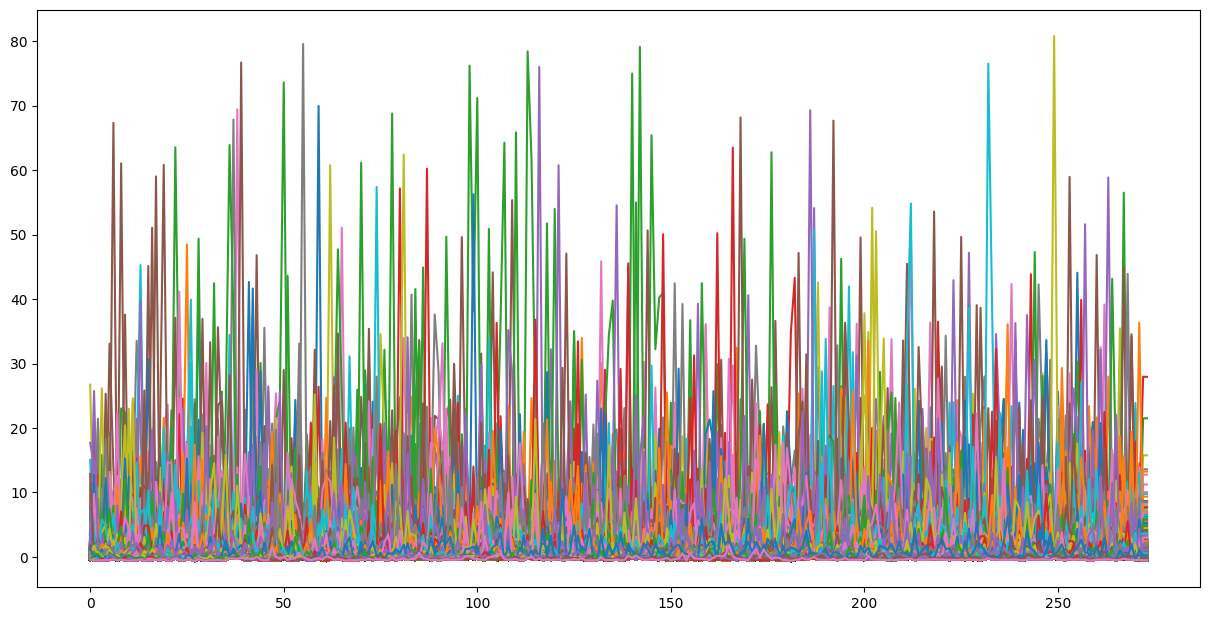

In [7]:
plt.plot(list_cli[0].T)

In [8]:
print(list_cli[0].shape)

(7287, 274)


In [8]:
from IPython.display import clear_output

def upsample(x, samples=15000):
    x = np.array(x)
    x_new = np.zeros((samples, x.shape[1]))
    old_samples = x.shape[0]
    for i in range(samples):
        clear_output(wait=True)
        print(i, flush=True)
        
        new_vec = x[np.random.randint(x.shape[0])]
        scale = np.std(new_vec) / 10 # noise 10 times smaller than the signal
        new_vec += np.random.normal(loc=0.0, scale=scale, size=new_vec.shape)
        
        x_new[i] = new_vec
    return np.array(x_new)

In [16]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

list_cli_new = []
num_cli = 15000

for num, item in enumerate(list_cli):

    X = item
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    X_train, X_test = X_train.astype('float32'), X_test.astype('float32')

    #print(X_train.shape)
    #print(X_test.shape)

    def create_autoencoder(num_cli=7500):
    
        # ENCODER
        input_ts = Input(shape=(X.shape[1],))
        encoded = Dense(64, activation='relu')(input_ts)
        encoded = Dense(32, activation='relu')(encoded)
    
        # DECODER
        input_encoded = Input(shape=(32,))
        decoded = Dense(64, activation='sigmoid')(input_encoded)
        decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

        # MODELS
        encoder = Model(input_ts, encoded, name="encoder")
        decoder = Model(input_encoded, decoded, name="decoder")
        autoencoder = Model(input_ts, decoder(encoder(input_ts)), name="autoencoder")
        return encoder, decoder, autoencoder
    
    encoder, decoder, autoencoder = create_autoencoder(num_cli)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(X_train, X_train,
                    epochs=150,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(X_test, X_test))
    
    encoded_ts = encoder.predict(X)
    upsampled_encoding = upsample(encoded_ts, num_cli)
    print(f"Shape of upsampled: {upsampled_encoding.shape}")
    decoded_ts = decoder.predict(upsampled_encoding)
    
    scaler = list_scalers[num]
    final_data = scaler.inverse_transform(decoded_ts)
    
    print(f"GROUP: {num}")
    list_cli_new.append(final_data)

14999
Shape of upsampled: (15000, 32)
469/469 [==============================] - 0s 549us/step
GROUP: 13


In [17]:
list_cli_new = np.array(list_cli_new)
print(f"Shape before: {list_cli_new.shape}")
client_df = np.swapaxes(list_cli_new, 0, 1)
print(f"Shape after: {client_df.shape}")

np.savez('./sber_work_files/final/synt_clients_w_gr_names_ver2.npz', \
         group_names=group_names, \
         client_df=client_df)

Shape before: (14, 15000, 274)
Shape after: (15000, 14, 274)
